In [6]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats
from dgp.scm import SimpleSCM

plt.style.use('fivethirtyeight')

# Causal Secrets Mini-Course
## Secret 1 - Lecture 2

This notebook is a part of the [Causal Secrets Mini-Course](https://causalsecrets.com/).

<a href="https://causalpython.io"><img src="img/CausalPython.io - Dark.png" width=200 align="left"></a>

In [7]:
# Instantiate the SCM (this object will generate the data for us)
scm = SimpleSCM(random_seed=37)

In [8]:
# Sample data from the SCM (observations)
x, y, z, w = scm.sample(310)

# Sample experimental data from the SCM (interventions/RCT)
x_rct = np.array([])
y_rct = np.array([])
z_rct = np.array([])
w_rct = np.array([])

for i in np.arange(-1, 30, 1):
    x_rct_local, y_rct_local, z_rct_local, w_rct_local = scm.intervene(
        i + random.gauss(mu=0, sigma=1), # Add variability to the treatment to de-quantize
        sample_size=10
    )
    x_rct = np.concatenate([x_rct, x_rct_local])
    y_rct = np.concatenate([y_rct, y_rct_local])
    z_rct = np.concatenate([z_rct, z_rct_local])
    w_rct = np.concatenate([w_rct, w_rct_local])

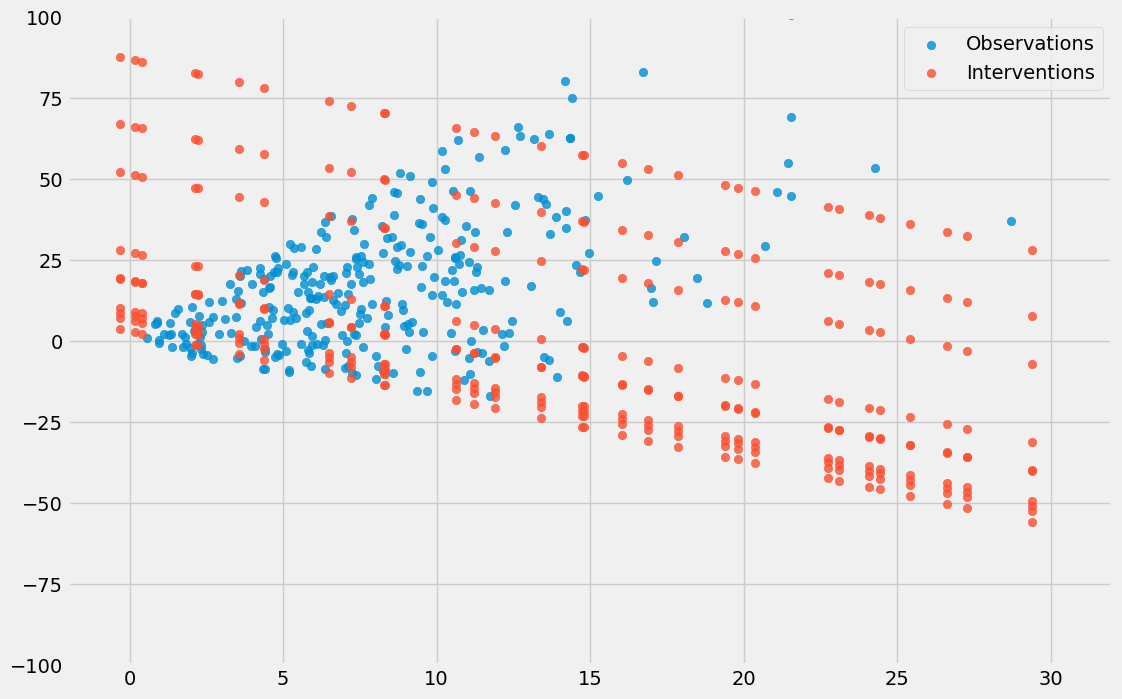

In [9]:
# Plot observational data and interventional data (X, Y)
plt.figure(figsize=(12, 8))
plt.scatter(x, y, label='Observations', alpha=.8)
plt.scatter(x_rct, y_rct, label='Interventions', alpha=.8)
plt.xlim(-2, 32)
plt.ylim(-100, 100)
plt.legend()
plt.show()

In [505]:
# Combine available analytic setups
analytic_setups = {
    'obs X': [x, y], 
    'obs X, Z': [x, z, y], 
    'obs X, Z, W': [x, z, w, y],
    'rct X': [x_rct, y_rct],
#     'rct X, W': [x_rct, w_rct, y_rct],
    'rct X, Z, W': [x_rct, z_rct, w_rct, y_rct],
}

# Store fitted models for each setup
models = {}

for s in analytic_setups:
    X = np.array(analytic_setups[s][:-1]).T
    X = sm.add_constant(X)
    y_local = analytic_setups[s][-1]
    model = sm.OLS(y_local, X)
    results = model.fit()
    models[s] = results

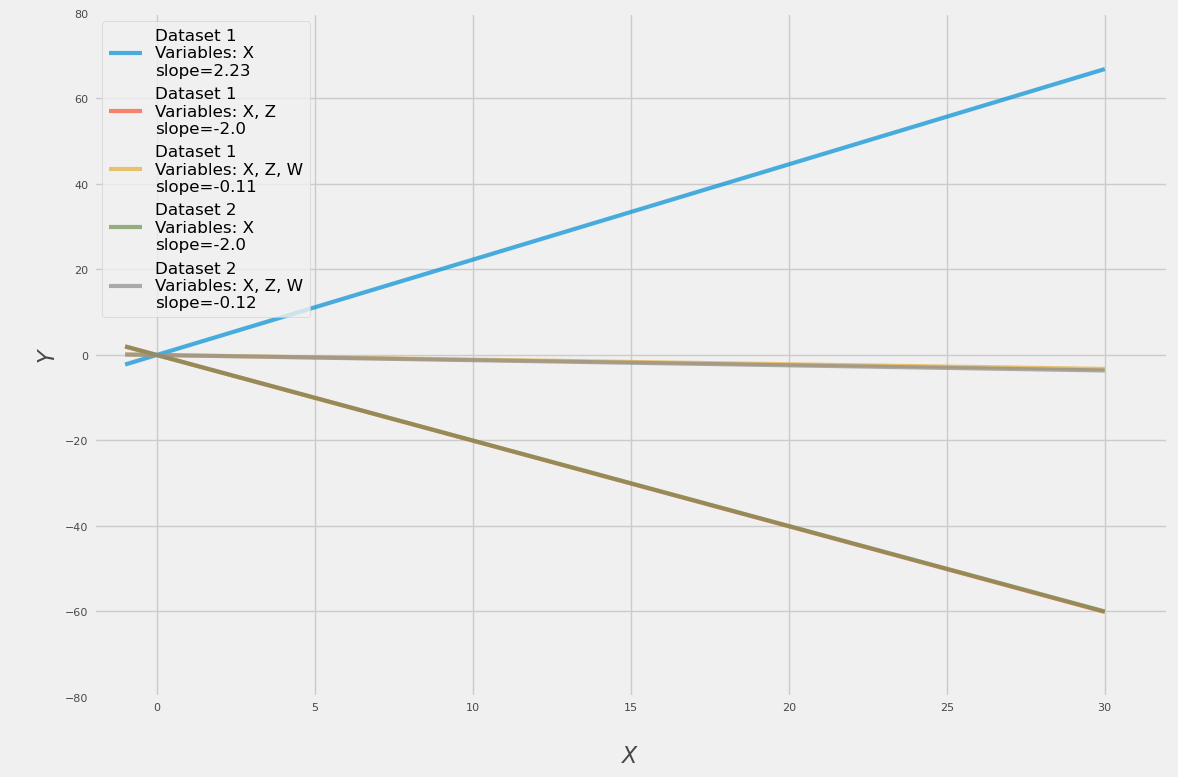

In [506]:
# Plot results
plt.figure(figsize=(12, 8))
for s in list(analytic_setups.keys())[:5]:
    
    params = models[s].params
    x_local = np.array([-1, 30])
    y_local = params[1]*x_local
    
    if s.startswith('obs'):
        dataset = 'Dataset 1'
    else:
        dataset = 'Dataset 2'
    
    plt.plot(
        x_local,
        y_local,
        label=f'{dataset}\nVariables: {s[4:]}\nslope={params[1].round(2)}',
        alpha=.7,
        lw=3
    )
    plt.xlim(-2, 32)
    plt.ylim(-80, 80)
    
plt.xlabel('\n$X$', fontsize=16, alpha=.7)
plt.ylabel('\n$Y$', fontsize=16, alpha=.7)
    
plt.xticks(fontsize=8, alpha=.7)
plt.yticks(fontsize=8, alpha=.7)

plt.tight_layout()
plt.legend(
    loc='upper left',
    prop={'size': 12},
)
plt.show()

In [507]:
for s in models:
    
    if s.startswith('obs'):
        dataset = 'Dataset 1'
    else:
        dataset = 'Dataset 2'
    
    print(f'{dataset}\nVariables: {s[4:]}\nslope={models[s].params[1].round(2)}')
    print(f'R^2 = {models[s].rsquared.round(3)}\nR^2_adj = {models[s].rsquared_adj.round(3)}')
    print(f'p = {models[s].pvalues.round(6)}')
    print(f'F-test p = {models[s].f_pvalue.round(6)}\n')

Dataset 1
Variables: X
slope=2.23
R^2 = 0.265
R^2_adj = 0.262
p = [0.50719 0.     ]
F-test p = 0.0

Dataset 1
Variables: X, Z
slope=-2.0
R^2 = 0.997
R^2_adj = 0.997
p = [0.548486 0.       0.      ]
F-test p = 0.0

Dataset 1
Variables: X, Z, W
slope=-0.11
R^2 = 1.0
R^2_adj = 1.0
p = [0.       0.       0.064081 0.      ]
F-test p = 0.0

Dataset 2
Variables: X
slope=-2.0
R^2 = 0.304
R^2_adj = 0.302
p = [0. 0.]
F-test p = 0.0

Dataset 2
Variables: X, Z, W
slope=-0.12
R^2 = 1.0
R^2_adj = 1.0
p = [0.       0.       0.000749 0.      ]
F-test p = 0.0

